In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import random

In [2]:
# ---------------------------- LOAD DATASET ---------------------------- #

# this command will download the LFW_people's dataset to hard disk.

lfw_people = fetch_lfw_people(data_home='D:\Senior II\Image Processing\Project\LFW Dataset',
# lfw_people = fetch_lfw_people(data_home='D:\Work\CCE\Year 4 - Senior 2\Semester 1\Senior-2-Semester-1\Image Processing\Project',
min_faces_per_person = 70, resize = 0.4)

In [3]:
images = lfw_people.images
print('Images shape:',images.shape)

total_images, height, width = images.shape
print(f'Each image has size: {height} x {width}')

print(70* '-')

m = int(total_images * 0.8)
print('M = Number of examples = ', m)

m_test = total_images - m
print('M_test = Number of test examples = ', m_test)

train_images = images[:int(m)]
print('Train images shape:', train_images.shape)

test_images = images[int(m):]
print('Test images shape:', test_images.shape)

n_features = height*width
print(f'N^2 = n_features = h x w = {n_features}')

print(70* '-')

y = lfw_people.target
print('y has shape:', y.shape)

y_train = y[:int(m)]
print('y_train has shape:', y_train.shape)

y_test = y[int(m):]
print('y_test has shape:', y_test.shape)

target_names = lfw_people.target_names
num_people = target_names.shape[0]
print('Number of people =', num_people)

Images shape: (1288, 50, 37)
Each image has size: 50 x 37
----------------------------------------------------------------------
M = Number of examples =  1030
M_test = Number of test examples =  258
Train images shape: (1030, 50, 37)
Test images shape: (258, 50, 37)
N^2 = n_features = h x w = 1850
----------------------------------------------------------------------
y has shape: (1288,)
y_train has shape: (1030,)
y_test has shape: (258,)
Number of people = 7


In [4]:
print(target_names)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']


In [5]:
#----------------------- CREATE PEOPLE DICTIONARY -----------------------#

# Key: person ID
# Value: List of all person images indices
person_image_dict = dict()

for image_index in range(m):
    if (y_train[image_index] not in person_image_dict.keys()):
        person_image_dict[y_train[image_index]] = [image_index]
    else:
        person_image_dict[y_train[image_index]].append(image_index)

George W Bush


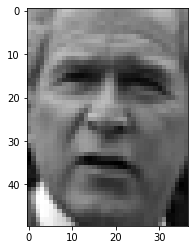

In [6]:
# ------------------ VIEW RANDOM IMAGE ------------------ #
index = int(random.random() * m)
image = images[index,:,:]
name = target_names[y[index]]

print(name)
plt.imshow(image, cmap='gray')
plt.show()

In [7]:
# --------------------- GET FLATTEN IMAGES --------------------- #

# Flatten images array
# Each column is an image

# N^2 * M
flattened_images = train_images.reshape(m, -1).T

# N^2 * M_test
flattened_test_images = test_images.reshape(m_test, -1).T

print(f'Shape of training images after flattening: {flattened_images.shape}')
print(f'Shape of test images after flattening: {flattened_test_images.shape}')

Shape of training images after flattening: (1850, 1030)
Shape of test images after flattening: (1850, 258)


Average image has shape: (1850, 1)


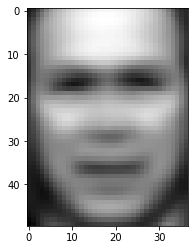

In [8]:
# ----------------- CALCULATE AVERAGE IMAGE ----------------- #

# In all corresponding pixels in all images, we calculate the average

# N^2 * 1
average_image = np.mean(flattened_images, axis = 1)[:,np.newaxis]

print(f'Average image has shape: {average_image.shape}')
plt.imshow(average_image.reshape(height,width), cmap='gray')
plt.show()

In [9]:
#-------------------------------- GET DIFFERENCE IMAGES --------------------------------#

# Subtract the average image from all images
# This is done to remove the average face from all images
# N^2 * M
difference_images = flattened_images - average_image

print(f'Shape after subtracting average face: {difference_images.shape}')


Shape after subtracting average face: (1850, 1030)


George W Bush


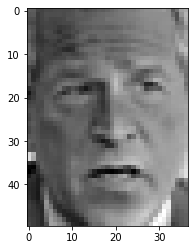

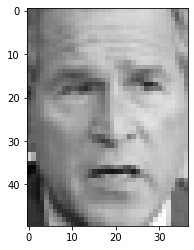

In [10]:
# --------------------- SHOW ONE DIFFERENCE IMAGE AND COMPARE TO ORIGINAL --------------------- #

index = int(random.random() * m)
name = target_names[y_train[index]]

print(name)
plt.imshow(difference_images[:,index].reshape(height, width), cmap='gray')
plt.show()

# Print original image
plt.imshow(images[index,:,:], cmap='gray')
plt.show()

In [11]:
#--------------------- GET COVARIANCE MATRIX --------------------- #

# C = A * A^T where A = difference_images

A = difference_images

# N^2 * N^2
covariance_matrix = np.matmul(difference_images, difference_images.T)

print('Shape of covariance matrix:', covariance_matrix.shape)

Shape of covariance matrix: (1850, 1850)


In [12]:
# --------------------------------- GET EIGENVALUES AND EIGENVECTORS --------------------------------- #

# Calculate the eigenvalues and eigenvectors of L
# where L = A^T * A

# M * M
L = np.matmul(A.T, A)

print('Shape of L:', L.shape)

# M eigenvalues and M eigenvectors
# where M is the number of examples

eigenvalues, eigenvectors = np.linalg.eig(L)
print('Shape of eigenvalues:', eigenvalues.shape)
print('Shape of eigenvectors:', eigenvectors.shape)


Shape of L: (1030, 1030)
Shape of eigenvalues: (1030,)
Shape of eigenvectors: (1030, 1030)


In [13]:
# ------------------------ GET EIGENFACES FOR ALL IMAGES ------------------------ #

# Those Eigenvectors determine linear combinations of the M training set face images 
# to form the eigenfaces U

# difference_images: N^2 * M
# difference_images[:, i, np.newaxis]: N^2 * 1

# eigenvectors: M * M
# eigenvectors[:, i, np.newaxis]: M * 1

# N^2 * M
eigenfaces = np.zeros((n_features, m))

# TODO optimize the for loop
for i in range(m):
    eigenfaces += np.matmul(difference_images[:, i, np.newaxis], eigenvectors[:, i, np.newaxis].T)

print('Shape of eigenfaces:', eigenfaces.shape)


Shape of eigenfaces: (1850, 1030)


In [14]:
# ------------------------ GET TOP EIGENFACES ------------------------ #

num_eigenfaces = 100

# Top eigenvalues indices
top_eigenvalues_indices = np.argsort(eigenvalues)[-num_eigenfaces:]

#  N^2 * num_eigenfaces
top_eigenfaces = np.zeros((n_features, num_eigenfaces))

i=0
for index in top_eigenvalues_indices:
    top_eigenfaces[:, i] = eigenfaces[:, index]
    i += 1

print(f"Top eigenfaces shape: {top_eigenfaces.shape}")

Top eigenfaces shape: (1850, 100)


George W Bush


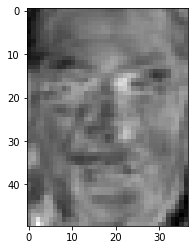

In [15]:
# ------------------------ SHOW A RANDOM EIGENFACE ------------------------ #

index = int(random.random() * m)
name = target_names[y_train[index]]

print(name)
plt.imshow(eigenfaces[:,index].reshape(height, width), cmap='gray')
plt.show()


George W Bush


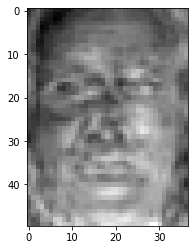

In [16]:
# ------------------------ SHOW A RANDOM EIGENFACE FROM TOP   ------------------------ #

index = int(random.random() * num_eigenfaces)
name = target_names[y_train[index]]

print(name)
plt.imshow(top_eigenfaces[:,index].reshape(height, width), cmap='gray')
plt.show()


In [17]:
# ------------------------ CALCULATING OMEGAS (OMEGA FOR EACH PERSON) ------------------------ #

# For each person, take a small number of face images (Here we took all), then calculate the eigenface representation of each image, then average it
# The result is the omega for that person omega is a vector of size num_eigenfaces with weight for each eigenface

# num_people * num_eigenfaces
omegas = np.zeros((num_people, num_eigenfaces))

for person in range(num_people):
    
    image = np.zeros((n_features, 1))
    
    image_indices = person_image_dict[person]
    
    # Loop over all images of a person
    for img in image_indices:
        # Get current Image of this person
        image = flattened_images[:, img, np.newaxis]
        # Get difference between current image and average image
        diff = image - average_image
        # Loop over all the top eigenfaces
        for i in range(num_eigenfaces):
            # Sum up the dot product of the difference image and the top eigenface
            omegas[person, i] += np.matmul(top_eigenfaces[:, i, np.newaxis].T , diff)
            
    omegas[person,:] = omegas[person,:] / len(image_indices)
    
print(f"Omegas shape: {omegas.shape}")

Omegas shape: (7, 100)


## Testing

Test image has shape: (1850, 1)
shape of w: (100,)
1850


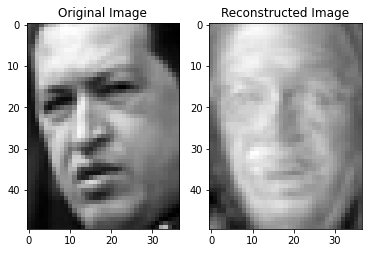

Distance between test image and Ariel Sharon is 87.88837303986821
Distance between test image and Colin Powell is 87.6857564114717
Distance between test image and Donald Rumsfeld is 84.20264541436778
Distance between test image and George W Bush is 85.34992484877351
Distance between test image and Gerhard Schroeder is 86.49604876038144
Distance between test image and Hugo Chavez is 92.58744020407619
Distance between test image and Tony Blair is 87.11390009731083
The nearest person is Donald Rumsfeld
True person: Donald Rumsfeld


In [27]:
# -------------------------------------- TESTING SINGLE IMAGE -------------------------------------- #

index = int(random.random() * test_images.shape[0])

test_image = flattened_test_images[:,index, np.newaxis]
print(f'Test image has shape: {test_image.shape}')

w = np.zeros((num_eigenfaces,))
diff = test_image - average_image

for i in range(num_eigenfaces):
    w[i] = np.matmul(eigenfaces[:,i, np.newaxis].T,diff)
    
print(f"shape of w: {w.shape}")


# Visualize the image as a linear combination of the eigenfaces
print(n_features)
reconstructed_image = np.zeros((n_features,))
for i in range(num_eigenfaces):
    reconstructed_image += w[i] * eigenfaces[:,i]


# Show the reconstructed image and the original image next to each other
plt.subplot(1, 2, 1, title='Original Image')
plt.imshow(test_image.reshape(height, width), cmap='gray')
plt.subplot(1, 2, 2, title='Reconstructed Image')
plt.imshow(reconstructed_image.reshape(height, width), cmap='gray')
plt.show()




# Calculate the distance between w of the test image and omegas of all people
# The person with the smallest distance is the person in the test image

min_distance = float('inf')
nearest_person = -1

for person in range(num_people):
    distance = np.linalg.norm(w - omegas[person, :])
    if(distance < min_distance):
        min_distance = distance
        nearest_person = person
    print(f'Distance between test image and {target_names[person]} is {distance}')

threshold = float('inf')
if (min_distance < threshold):
    print(f'The nearest person is {target_names[nearest_person]}')
    print(f'True person: {target_names[y[index]]}')
else:
    print('No person found')

In [28]:
# ---------------------------- TESTING ACCURACY ---------------------------- #

count = 0
trials = 1000
for trial in range(trials):
    # Get test image index randomly
    index = int(random.random() * m_test)
    
    # Get image
    test_image = flattened_test_images[:,index, np.newaxis]

    # Calculate the image weight
    w = np.zeros((num_eigenfaces,))
    for i in range(num_eigenfaces):
        w[i] = np.matmul(eigenfaces[:,i, np.newaxis].T, test_image - average_image)

    min_distance = float('inf')
    nearest_person = -1

    for person in range(num_people):
        distance = np.linalg.norm(w - omegas[person,:])
        if(distance < min_distance):
            min_distance = distance
            nearest_person = person

    threshold = float('inf')
    if (min_distance < threshold):
        if(nearest_person == y_test[index]):
            count += 1
print(f'Accuracy: {count/trials*100}%')

Accuracy: 27.700000000000003%
